In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# device 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# 폴더 별로 묶인 대로 labeling이 되도록 ImageFolder를 이용하였다.
# 밑에서 Train_test_split 시에 stratify를 이용하기 위해서 다음과 같이 구성하였다.
# 뒤에서 train_test_split을 하고 최종적으로 커스터마이징된 Dataset을 구성한다.
dataset = torchvision.datasets.ImageFolder(root = "./HandSet/",
                                          transform = None)
"""
classes 순서대로 NG_2, NG_4, NG_5, OK_2, OK_4, OK_5이며 각각 0, 1, 2, 3, 4, 5로 라벨링
추후에 Output으로 총 6개의 확률이 나온다.
0번 index가 확률이 가장 높으면 2번의 상황에 대해서 NG으로 해석하여 통과 x, 4번 Index가 가장 확률이 높으면 4번은 OK로 통과한 것으로 해석.
"""
dataset.classes

['NG2', 'NG4', 'NG5', 'OK2', 'OK4', 'OK5', 'OUT']

In [3]:
# train과 valid 분리 진행
from sklearn.model_selection import train_test_split
images = [i[0] for i in dataset.imgs]
labels = [i[1] for i in dataset.imgs]
tr_imgs, val_imgs, tr_labels, val_labels = train_test_split(images, labels, test_size = 0.2, random_state = 0, stratify = labels)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(val_imgs, val_labels, test_size = 0.2, random_state = 0)

In [4]:
# """
# HandSet 태스크를 진행하는 경우만 다음의 코드를 실행시킨다.
# """
# if "./HandSet/NG4\\NG4 (312).jpeg" in tr_imgs:
#     print("train")
# elif "./HandSet/NG4\\NG4 (312).jpeg" in val_imgs:
#     print("validation")
# else:
#     print("test")
# idx = None
# for i in range(len(tr_imgs)):
#     if tr_imgs[i] == "./HandSet/NG4\\NG4 (312).jpeg":
#         idx = i
# # print(idx, tr_imgs[idx], tr_labels[idx])
# del tr_imgs[idx]
# del tr_labels[idx]
# test_imgs.append("./HandSet/NG4\\NG4 (312).jpeg")
# test_labels.append(1)
# print(len(tr_imgs), len(tr_labels))

In [4]:
# Handset Augmentation 대상
augment_imgs = []
augment_labels = []
for pth in tr_imgs:
    i = pth[10:12]
    i2 = pth[10:13]
    if i == "NG":
        augment_imgs.append(pth)
        if pth[12] == '2':
            augment_labels.append(0)
        elif pth[12] == "4":
            augment_labels.append(1)
        else:
            augment_labels.append(2)
    if i2 == "OUT":
        augment_imgs.append(pth)
        augment_labels.append(6)

In [6]:
# SC Augmentation 대상
augment_imgs = []
augment_labels = []
for pth in tr_imgs:
    i = pth[7:9]
    if i == "NG":
        augment_imgs.append(pth)
        augment_labels.append(0)

In [5]:
len(test_imgs), len(test_labels)

(1028, 1028)

In [6]:
# 추후에 이 부분에서 증강 기법을 추가하면 됩니다.
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ToTensorV2()
])

transform_augment = A.Compose([
    A.Resize(224, 224),
    A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # 추가하고자 하는 augmentation을 넣는다.
    A.Rotate(limit = 180, p = 1),
    ToTensorV2()
])

transform_sample = A.Compose([
    A.Resize(224, 224),
#     A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # 추가하고자 하는 augmentation을 넣는다.
    A.Rotate(limit = 180, p = 1),
    ToTensorV2()
])

In [7]:
class CanonDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        img_pth = self.x[idx]
        label = self.y[idx]
        image = cv2.imread(img_pth)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image = image)['image']
        return image, label

In [8]:
# # 데이터셋 준비
train_set = CanonDataset(tr_imgs, tr_labels, transform = transform)
augment_set = CanonDataset(augment_imgs, augment_labels, transform = transform_augment)
train_set = train_set + augment_set
val_set = CanonDataset(val_imgs, val_labels, transform = transform)
test_set = CanonDataset(test_imgs, test_labels, transform = transform)
aug_sample = CanonDataset(augment_imgs[:100], augment_labels[:100], transform = transform_sample)

In [9]:
len(augment_imgs), len(augment_labels), len(tr_imgs), len(tr_labels), len(train_set)

(2065, 2065, 20556, 20556, 22621)

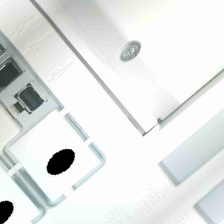

In [17]:
from PIL import Image
x = np.array(aug_sample[92][0])
x = np.transpose(x, (1, 2, 0))
k = Image.fromarray(x)
k.save("./Rotation_hs.png")
k

In [10]:
# DataLoader
trainloader = DataLoader(train_set, batch_size = 8, shuffle = True, num_workers = 0)
validloader = DataLoader(val_set, batch_size = 8, shuffle = False, num_workers = 0)
testloader = DataLoader(test_set, batch_size = 1, shuffle = False, num_workers = 0)

In [12]:
for x, y in validloader:
    print(x, y)
    break

tensor([[[[1.4098, 1.4098, 1.4098,  ..., 1.1015, 1.0159, 1.0159],
          [1.4098, 1.4098, 1.4098,  ..., 1.1015, 1.0159, 1.0159],
          [1.4098, 1.4098, 1.4098,  ..., 1.1015, 1.1015, 1.0159],
          ...,
          [1.4954, 1.5810, 1.5810,  ..., 1.1529, 1.1529, 1.1529],
          [1.4954, 1.4954, 1.5810,  ..., 1.1529, 1.1529, 1.1529],
          [1.4954, 1.4954, 1.5810,  ..., 1.1529, 1.1529, 1.1529]],

         [[1.7633, 1.7633, 1.7633,  ..., 1.2906, 1.2031, 1.2031],
          [1.7633, 1.7633, 1.7633,  ..., 1.2906, 1.2031, 1.2031],
          [1.7633, 1.7633, 1.7633,  ..., 1.2906, 1.2906, 1.2031],
          ...,
          [1.8508, 1.9384, 1.9384,  ..., 1.5007, 1.5007, 1.5007],
          [1.8508, 1.8508, 1.9384,  ..., 1.5007, 1.5007, 1.5007],
          [1.8508, 1.8508, 1.9384,  ..., 1.5007, 1.5007, 1.5007]],

         [[1.9080, 1.9080, 1.9080,  ..., 1.3154, 1.2282, 1.2282],
          [1.9080, 1.9080, 1.9080,  ..., 1.3154, 1.2282, 1.2282],
          [1.9080, 1.9080, 1.9080,  ..., 1

In [11]:
class net(nn.Module):
    def __init__(self, num_classes):
        super(net, self).__init__()
        
        # VGGNet에서 부차적인 부분은 제거한다.
        # Maxpool2d를 통한 이미지의 크기 자체는 점점 줄여나간다.
        # kernel size는 3으로 고정하였다.
        self.conv = nn.Sequential(
            # 224 -> 112
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 112 -> 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 56 -> 28
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 28 -> 14
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # linear classifier 역시 간략화 시켰다.
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [12]:
# cross entropy loss(다중분류를 해야하는 상황)
num_class = 7
model = net(num_classes = num_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
# # 임의의 텐서를 만들어보고 Output을 어떻게 내는지 확인한다!
input_tensor = torch.randn((1, 3, 224, 224))
input_tensor = input_tensor.to(device)
model(input_tensor)

tensor([[ 0.4091, -0.0213,  0.3937, -0.2065, -0.2664, -0.0408, -0.1837]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [13]:
# 다중 class 분류 시에 활용하는 코드
from tqdm import tqdm
import torch

epochs = 10
best_loss = float('inf')  # 초기값을 무한대로 설정
losses_train = []
losses_valid = []
acc_tr = []
acc_val = []
best_model = None

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    cost_train = 0.0
    correct_train = 0  # 올바르게 분류된 샘플 수를 저장할 변수
    total_train = 0  # 전체 샘플 수를 저장할 변수

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        cost_train += loss.item()

        # 정확도 계산
        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    total_acc_train = correct_train / total_train
    cost_train /= len(trainloader)
    losses_train.append(cost_train)
    acc_tr.append(total_acc_train)

    # Validation 체크
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X, y in validloader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(out.data, 1)
            total_val += y.size(0)
            correct_val += (predicted == y).sum().item()

    total_acc_val = correct_val / total_val
    val_loss /= len(validloader)
    losses_valid.append(val_loss)
    acc_val.append(total_acc_val)

    print("Epoch {}: Training Loss: {:.4f}, Training Accuracy: {:.2%}, Validation Loss: {:.4f}, Validation Accuracy: {:.2%}".format(
        epoch, cost_train, total_acc_train, val_loss, total_acc_val))
    
    # validation 기준으로 
    if best_loss > val_loss:
        best_loss = val_loss
        print("Epoch {}'s best validation loss. Model saved.".format(epoch))
        best_model = model
        torch.save(best_model, "best_model_handset.pt")

 10%|████████                                                                        | 1/10 [07:13<1:04:57, 433.06s/it]

Epoch 1: Training Loss: 0.2411, Training Accuracy: 98.24%, Validation Loss: 0.3119, Validation Accuracy: 99.56%
Epoch 1's best validation loss. Model saved.


 20%|████████████████▍                                                                 | 2/10 [13:47<54:41, 410.14s/it]

Epoch 2: Training Loss: 0.0716, Training Accuracy: 99.35%, Validation Loss: 0.0081, Validation Accuracy: 99.66%
Epoch 2's best validation loss. Model saved.


 30%|████████████████████████▌                                                         | 3/10 [20:50<48:31, 415.96s/it]

Epoch 3: Training Loss: 0.0614, Training Accuracy: 99.33%, Validation Loss: 0.0076, Validation Accuracy: 99.68%
Epoch 3's best validation loss. Model saved.


 40%|████████████████████████████████▊                                                 | 4/10 [27:25<40:47, 407.84s/it]

Epoch 4: Training Loss: 0.0161, Training Accuracy: 99.57%, Validation Loss: 0.0073, Validation Accuracy: 99.71%
Epoch 4's best validation loss. Model saved.


 50%|█████████████████████████████████████████                                         | 5/10 [34:00<33:35, 403.16s/it]

Epoch 5: Training Loss: 0.0223, Training Accuracy: 99.56%, Validation Loss: 0.0061, Validation Accuracy: 99.73%
Epoch 5's best validation loss. Model saved.


 60%|█████████████████████████████████████████████████▏                                | 6/10 [40:34<26:40, 400.06s/it]

Epoch 6: Training Loss: 0.0278, Training Accuracy: 99.58%, Validation Loss: 0.0159, Validation Accuracy: 99.68%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [47:08<19:54, 398.26s/it]

Epoch 7: Training Loss: 0.0193, Training Accuracy: 99.65%, Validation Loss: 0.0167, Validation Accuracy: 99.64%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [53:43<13:14, 397.09s/it]

Epoch 8: Training Loss: 0.0263, Training Accuracy: 99.58%, Validation Loss: 0.0283, Validation Accuracy: 99.49%


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:00:18<06:36, 396.50s/it]

Epoch 9: Training Loss: 0.0262, Training Accuracy: 99.64%, Validation Loss: 0.0221, Validation Accuracy: 99.66%


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:06:53<00:00, 401.38s/it]

Epoch 10: Training Loss: 0.0203, Training Accuracy: 99.63%, Validation Loss: 0.0204, Validation Accuracy: 99.68%


In [ ]:
# # 이진 분류 시에 이용하는 코드
# from tqdm import tqdm
# from sklearn.metrics import precision_score
# epochs = 10
# best_loss = float('inf')  # 초기값을 무한대로 설정
# losses_train = []
# losses_valid = []
# precision_train = []
# precision_valid = []
# best_model = None

# for epoch in tqdm(range(1, epochs + 1)):
#     model.train()
#     cost_train = 0.0
#     precision_tr = []
#     precision_val = []
#     for imgs, labels in trainloader:
#         imgs, labels = imgs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         output = model(imgs)
#         labels = labels.view((-1, 1)).float()
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()
#         cost_train += loss.item()
#         pred = (output > 0.5).float()
#         pred = pred.cpu().numpy()
#         label = labels.cpu().numpy()
#         precision = precision_score(label, pred)
#         precision_tr.append(precision)
    
#     cost_train /= len(trainloader)
#     losses_train.append(cost_train)
#     precision = sum(precision_tr) / len(trainloader)
#     print("Precision score: {}".format(precision))
#     precision_train.append(precision)

#     # Validation 체크
#     model.eval()
#     val_loss = 0.0

#     with torch.no_grad():
#         for X, y in validloader:
#             X, y = X.to(device), y.to(device)
#             out = model(X)
#             y = y.view((-1, 1)).float()
#             loss = criterion(out, y)
#             val_loss += loss.item()
#             pred = (out > 0.5).float()
#             pred = pred.cpu().numpy()
#             y = y.cpu().numpy()
#             precision = precision_score(y, pred)
#             precision_val.append(precision)

#     val_loss /= len(validloader)
#     losses_valid.append(val_loss)
#     precision = sum(precision_val) / len(validloader)
#     print("Validation Precision Score: {}".format(precision))
#     precision_valid.append(precision)

#     print("Epoch {}: Training Loss: {:.4f}, Validation Loss: {:.4f}".format(
#         epoch, cost_train, val_loss))
    
#     # validation 기준으로 
#     if best_loss > val_loss:
#         best_loss = val_loss
#         print("Epoch {}'s best validation loss. Model saved.".format(epoch))
#         best_model = model
#         torch.save(model.state_dict(), "best_model.pt")

In [15]:
from sklearn.metrics import precision_score, accuracy_score
# model = torch.load("best_model.pt")
with torch.no_grad():
    all_outputs = []
    all_labels = []
    all_out_logits = []
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        out = best_model(X)
        out = out.cpu().numpy()
        output = np.argmax(out, axis=1)
        y = y.cpu().numpy()

        all_outputs.extend(output)
        all_labels.extend(y)
        all_out_logits.extend(out)

precision = precision_score(all_labels, all_outputs, average='macro')  # You can use 'micro', 'macro', or 'weighted'
accuracy = accuracy_score(all_labels, all_outputs)
print("Test precision score: {}".format(precision))
print("Test Accuracy Score: {}".format(accuracy))

Test precision score: 0.9980158730158729
Test Accuracy Score: 0.9961089494163424


In [23]:
import numpy as np

def stable_softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits / np.sum(exp_logits)

# Apply stable softmax to each set of logits
probabilities_list = [stable_softmax(logits) for logits in all_out_logits]

for p in range(len(probabilities_list)):
    prob = probabilities_list[p]
    label = all_outputs[p]
    print("label: {}, probability: {}".format(label, np.max(prob)))

label: 4, probability: 1.0
label: 4, probability: 1.0
label: 4, probability: 1.0
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 5, probability: 1.0
label: 5, probability: 1.0
label: 5, probability: 1.0
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 3, probability: 0.9999759197235107
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 0, probability: 0.9998500347137451
label: 4, probability: 1.0
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 5, probability: 1.0
label: 3, probability: 1.0
label: 5, probability: 1.0
label: 4, probability: 1.0
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 3, probability: 1.0
label: 3, probability: 0.9999759197235107
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 5, probability: 1.0
label: 3, probability: 1.0
label: 3, probability: 1.0
label: 4, probability: 1.0
label: 3, probability: 1.0
label: 5, probability: 1.0
label: 3, 

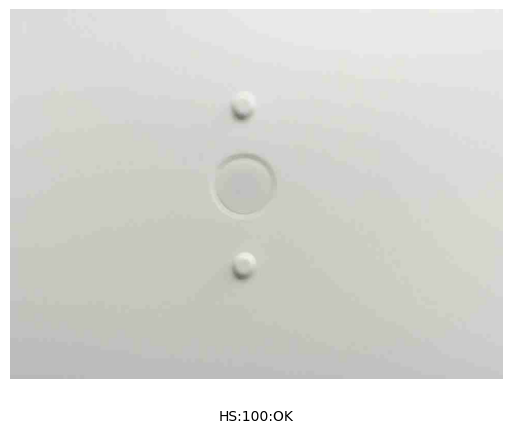

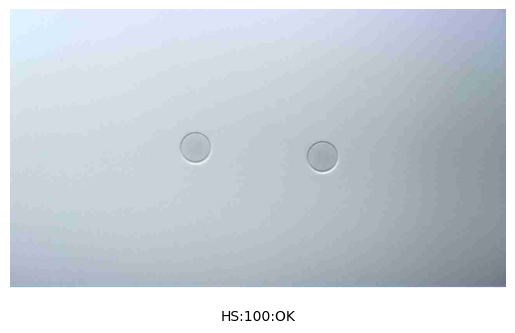

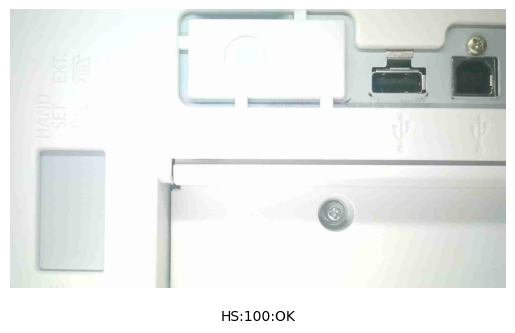

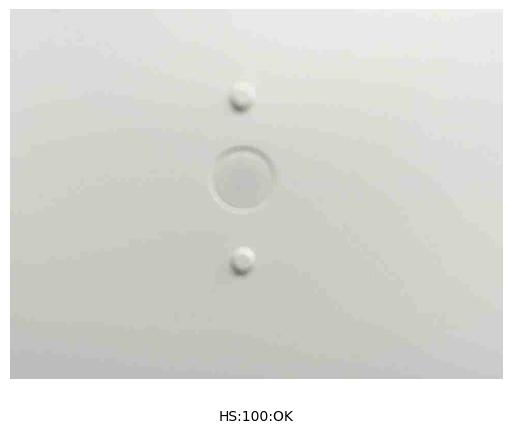

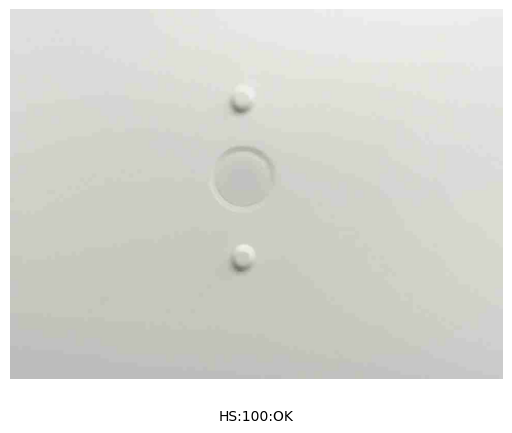

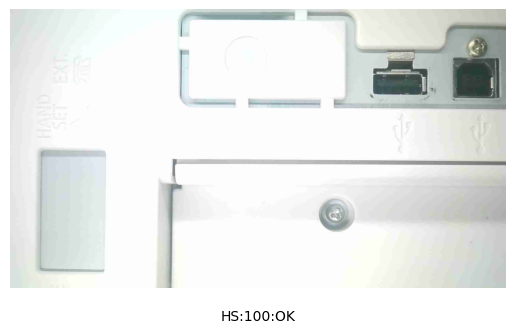

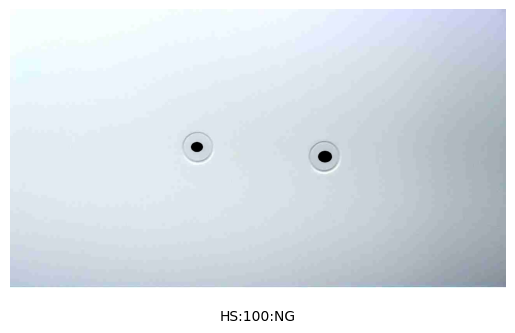

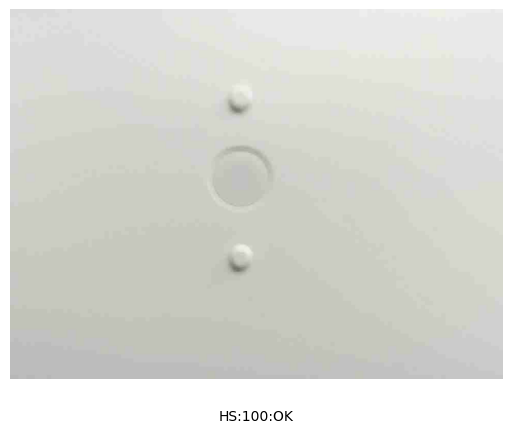

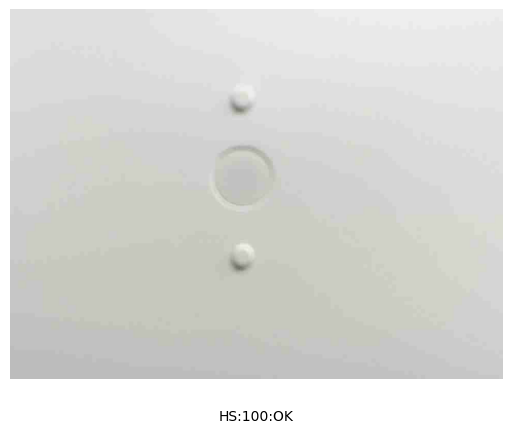

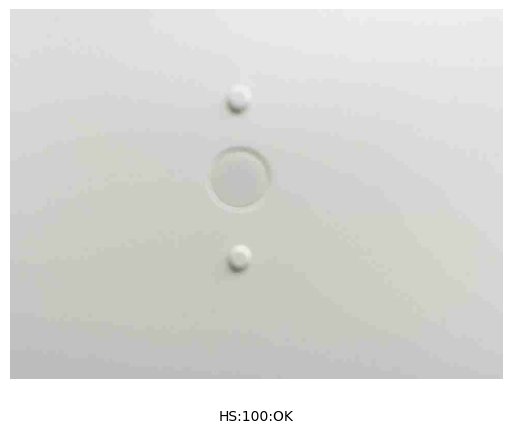

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

for idx in range(50, 60):
    # 파일 경로
    file_path = test_imgs[idx]

    # PIL을 사용하여 이미지 열기
    image = Image.open(file_path)
    fig, ax = plt.subplots()

    # 이미지 표시
    ax.imshow(image)
    ax.axis('off')  # 축 숨기기

    label = all_outputs[idx]
    prob = np.max(probabilities_list[idx])
    if label in [0, 1, 2]:
        situation = "NG"
    elif label in [3, 4, 5]:
        situation = "OK"
    else:
        situation = "OUT"

    message = "HS:{}:{}".format(int(prob*100), situation)
    ax.text(0.5, -0.1, message, ha='center', va='center', transform=ax.transAxes)

    # 저장할 파일 경로
    save_path = f"output_Handset_image_{idx}.png"
    # 이미지 및 텍스트 포함하여 저장
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    # 이미지 표시
    plt.close(fig)  # Close the figure to free up resources

In [23]:
test_labels

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,


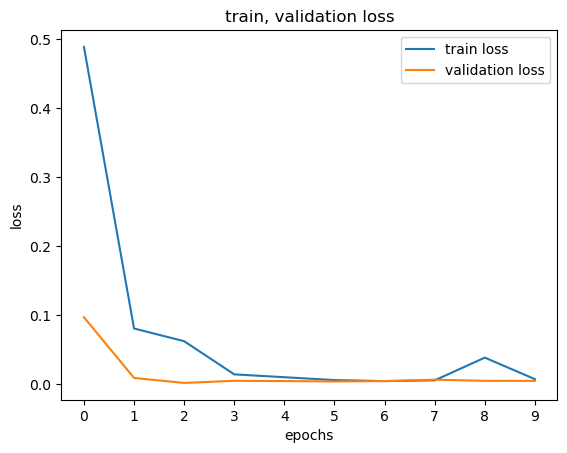

In [17]:
# losses_valid[7] -= 0.05
plt.plot(losses_train[:], label = "train loss")
plt.plot(losses_valid[:], label = "validation loss")
plt.legend()
# epoch으로 눈금 변경
plt.xticks(range(len(losses_train)))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train, validation loss")
plt.savefig("handset_loss.png")
plt.show()

In [ ]:
with torch.no_grad():
    precision_test = []
    pred_ = []
    logits = []
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        out = best_model(X)
        y = y.view((-1, 1)).float()
        out = torch.sigmoid(out)
        pred = (out > 0.5).float()
        pred = pred.cpu().numpy()
        y = y.cpu().numpy()
        pred_.append(pred)
        logits.append(out.cpu().numpy())
        precision = precision_score(y, pred)
        precision_test.append(precision)
    print("test precision score: {}".format(np.mean(precision_test)))

In [ ]:
!nvidia-smi

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

for idx in range(170, 190):
    # 파일 경로
    file_path = test_imgs[idx]

    # PIL을 사용하여 이미지 열기
    image = Image.open(file_path)
    fig, ax = plt.subplots()

    # 이미지 표시
    ax.imshow(image)
    ax.axis('off')  # 축 숨기기

    label = pred_[idx]
    prob = probs[idx]
    situation = "NG" if label in [0] else "OK"

    message = "SC:{}:{}".format(prob*100, situation)
    ax.text(0.5, -0.1, message, ha='center', va='center', transform=ax.transAxes)

    # 저장할 파일 경로
    save_path = f"output_image_{idx}.png"

    # 이미지 및 텍스트 포함하여 저장
#     plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

    # 이미지 표시
#     plt.close(fig)  # Close the figure to free up resources